In [1]:
import cv2
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import re
import numpy as np
import scipy
import skimage
import ants
# downscale = 4
# img_path = "/storage/valis_reg/BFIW_Block/msrcr"
# img_paths = [os.path.join(img_path, img) for img in os.listdir(img_path)]
# save_paths = [os.path.join("/storage/valis_reg/BFIW_Block_low_res/msrcr", img) for img in os.listdir(img_path)]


# def store_downscaled_image(img_path, save_path):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (img.shape[1]//downscale, img.shape[0]//downscale))
#     cv2.imwrite(save_path, img)

# _ = Parallel(n_jobs=16)(delayed(store_downscaled_image)(img_path, save_path) for img_path, save_path in tqdm(zip(img_paths, save_paths)))

In [2]:
import numpy as np
import cv2

def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr

def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li
                        else (255 if i > hi else round((i - li) / (hi - li) * 255))
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=3):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr_ = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr_ = cv2.normalize(msrcr_, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3) # type: ignore
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr_ = color_balance(msrcr_, low_per, high_per)

    return msrcr_

In [3]:
class BFIWSlide:
    def __init__(self, slide_path, key=None, is_ref=False):
        self.slide_path = slide_path
        self.key = key
        self.img = cv2.imread(slide_path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.msr_img = None
        self.msr_img_gray = None
        self.mask = None
        self.is_ref = is_ref
        self.apply_msrcr()
        self.get_mask()
        self.apply_mask(self.mask)

    def apply_msrcr(self):
        self.msr_img = msrcr(self.img)
        self.msr_img_gray = cv2.cvtColor(self.msr_img, cv2.COLOR_RGB2GRAY)

    def apply_mask(self, mask):
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.img[mask == 1]
        self.img = self.temp_img
        self.temp_img = (np.ones_like(self.img) * 255).astype(np.uint8)
        self.temp_img[mask == 1] = self.msr_img[mask == 1]
        self.msr_img = self.temp_img

    def get_mask(self):
        if self.msr_img_gray is None:
            self.apply_msrcr()
        sample_ants = ants.from_numpy(self.msr_img_gray)
        self.mask = sample_ants.get_mask(cleanup=4).numpy().astype(np.uint8) # type: ignore
        # return self.mask
    
    def apply_crop(self, crop):
        self.img = self.img[crop[0]:crop[1], crop[2]:crop[3]]
        self.msr_img = self.msr_img[crop[0]:crop[1], crop[2]:crop[3]]
        self.mask = self.mask[crop[0]:crop[1], crop[2]:crop[3]]

In [4]:
def make_slide(slide_path, key=None, is_ref=False):
    slide = BFIWSlide(slide_path, key, is_ref)
    return {key: slide}


class BFIWReg:
    def __init__(self, src_dir, dest_dir, ref_idx) -> None:
        self.src_dir = src_dir
        self.dest_dir = dest_dir
        imgs = os.listdir(self.src_dir)
        regex = re.compile(r".*-SE_(\d+)_original.jpg")
        imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
        imgs_ordered = {}
        for img in imgs:
            section_num = int(regex.match(img).group(1))
            section_id = str(section_num)
            section_id_digits = len(section_id)
            if section_id_digits <4:
                section_id = '0'*(4-section_id_digits) + str(section_num)
            imgs_ordered[section_id] = os.path.join(self.src_dir, img)
        self.imgs = imgs_ordered
        if ref_idx not in self.imgs:
            raise ValueError("Reference index not found in the image list")
        # self.ref_slide = BFIWSlide(self.imgs[ref_idx], key=ref_idx, is_ref=True)
        self.slides_ = Parallel(n_jobs=32)(delayed(make_slide)(img, key) for key, img in tqdm(self.imgs.items()))
        self.slides = {}
        for slide in self.slides_:
            self.slides.update(slide)
        self.ref_slide = self.slides[ref_idx]
        self.ref_slide.is_ref = True
        print("Applying Reference Slide Mask to all slides")
        for key, slide in tqdm(self.slides.items()):
            if key == ref_idx:
                continue
            slide.apply_mask(self.ref_slide.mask)
        self.ref_contours, _ = cv2.findContours(self.ref_slide.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.ref_contours = sorted(self.ref_contours, key=cv2.contourArea, reverse=True)
        self.ref_contour = self.ref_contours[0]
        self.ref_bbox = cv2.boundingRect(self.ref_contour)
        self.ref_crop = (self.ref_bbox[1], self.ref_bbox[1] + self.ref_bbox[3], self.ref_bbox[0], self.ref_bbox[0] + self.ref_bbox[2])
        print("Applying Reference Slide Crop to all slides")
        for key, slide in tqdm(self.slides.items()):
            slide.apply_crop(self.ref_crop) 
    
    def save_output(self):
        print("Saving `img` and `msr_img` of all slides")
        if not os.path.exists(self.dest_dir):
            os.makedirs(self.dest_dir, exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "msrcr")):
            os.makedirs(os.path.join(self.dest_dir, "msrcr"), exist_ok=True)
        if not os.path.exists(os.path.join(self.dest_dir, "original")):
            os.makedirs(os.path.join(self.dest_dir, "original"), exist_ok=True)
        for key, slide in tqdm(self.slides.items()):
            cv2.imwrite(os.path.join(self.dest_dir, f"original/{key}.jpg"), cv2.cvtColor(slide.img, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(self.dest_dir, f"msrcr/{key}_msrcr.jpg"), cv2.cvtColor(slide.msr_img, cv2.COLOR_RGB2BGR))

#### Copying Some Images to limit test cases

In [12]:
# import shutil
# from tqdm import tqdm
# orig_dir = '/storage/valis_reg/BFIW_original'
# files = os.listdir(orig_dir)
# samples = files[::60]
# for sample in tqdm(samples):
#     shutil.copy(os.path.join(orig_dir, sample), '/storage/valis_reg/test_block/'+sample)

100%|██████████| 44/44 [00:02<00:00, 17.72it/s]


In [21]:
reg = BFIWReg('/storage/valis_reg/test_block', '/storage/valis_reg/test_block_out', '1606')
reg.save_output()

100%|██████████| 63/63 [00:00<00:00, 21737.51it/s]


Applying Reference Slide Mask to all slides


100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Applying Reference Slide Crop to all slides


100%|██████████| 63/63 [00:00<00:00, 127039.02it/s]


Saving `img` and `msr_img` of all slides


100%|██████████| 63/63 [00:03<00:00, 16.50it/s]


In [5]:
import matplotlib.pyplot as plt


In [7]:
import glob
images = glob.glob('/storage/valis_reg/test_block_out/msrcr/*.jpg')
images = sorted(images, key=lambda x: int(x.split('/')[-1].split('_')[0]))
grid = int(np.ceil(np.sqrt(len(images))))
grid_loc = [(i, j) for i in range(grid) for j in range(grid)]
grid_loc = grid_loc[:len(images)]
image_data = []
for grid_pos, image_pth in zip(grid_loc,images):
    image = cv2.imread(image_pth)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_data.append(image)
dataset = [2,4,5,8,9,10,12,13,14,15,17,18,27,28,29,31,32,33,35,36,37,38,41,44,45,46,50,51,52,53,54,55,61]


In [22]:
def transform_img(image):
    # image = cv2.GaussianBlur(image, (9, 9), 5)
    green_thresh = skimage.filters.threshold_otsu(image[:,:,1])
    img_g = image[:,:,1] <= green_thresh
    img_g = scipy.ndimage.binary_fill_holes(img_g)
    img_g = scipy.ndimage.binary_closing(img_g, iterations=20)
    return img_g

# fig, ax = plt.subplots(grid, grid, figsize=(20, 10))
dataset = [2,4,5,8,9,10,12,13,14,15,17,18,27,28,29,31,32,33,35,36,37,38,41,44,45,46,50,51,52,53,54,55,61]
processed = []
for grid_pos, image in zip(grid_loc,image_data):
    idx = grid_pos[0]*grid + grid_pos[1]
    if idx not in dataset:
        continue
    img = transform_img(image)
    contours, _ = cv2.findContours(img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour = contours[0]
    # bbox = cv2.boundingRect(contour)
    # image = cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)
    contour_mask = np.zeros_like(img)
    contour_mask = cv2.fillPoly(contour_mask.astype(np.uint8), [contour], 1)
    foreground = cv2.bitwise_and(image, image, mask=contour_mask)
    background = cv2.bitwise_and(image, image, mask=1-contour_mask)
    processed.append({
        "fg" : foreground,
        "bg" : background,
        "mask" : contour_mask
    })
#     ax[grid_pos[0], grid_pos[1]].imshow(image)
#     ax[grid_pos[0], grid_pos[1]].axis('off')
#     ax[grid_pos[0], grid_pos[1]].set_title(f"{grid_pos[0]*grid + grid_pos[1]}")
# plt.show()

In [23]:
test_block2 = []
for idx in range(len(images)):
    if idx not in dataset:
        continue
    test_block2.append(images[idx])


In [27]:
import shutil
train_data_set_dir = '/storage/valis_reg/train_block'

os.makedirs(train_data_set_dir, exist_ok=True)
for img in pa:
    shutil.copy(img, train_data_set_dir)

In [26]:
pa  = ['/storage/valis_reg/test_block/B_213-ST_BFIW-SE_'+str(int(x.split('_')[0]))+'_original.jpg' for x in  os.listdir(train_data_set_dir)]

In [21]:
pa

[]

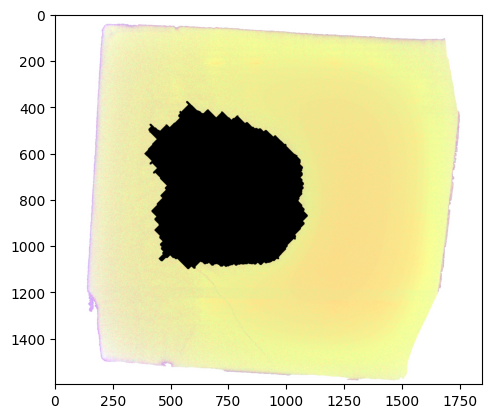

In [23]:
plt.imshow(processed[0]['bg'])

In [ ]:

# # image = cv2.imread('/storage/valis_reg/test_block_out/msrcr/1606_msrcr.jpg')
# Z = image.reshape((-1,3))
# Z = np.float32(Z)
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.2)
# K = 4
# ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# res2 = res.reshape((image.shape))
# plt.imshow(res2)
# # # kernel = kernel

# # dst = cv2.filter2D(image.copy(), -1, kernel)
# # # dst = cv2.filter2D(dst, -1, kernel)
# # # dst = cv2.filter2D(dst, -1, kernel)


# # plt.imshow(dst) 


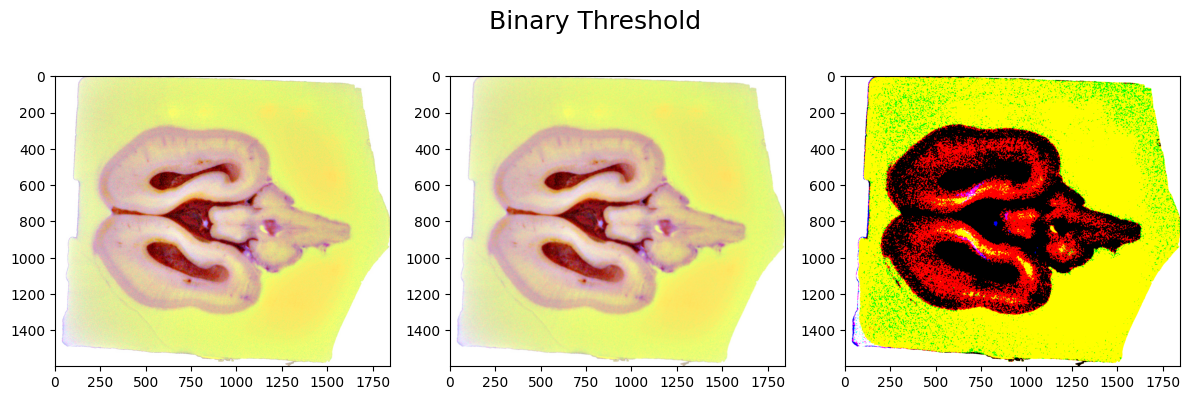

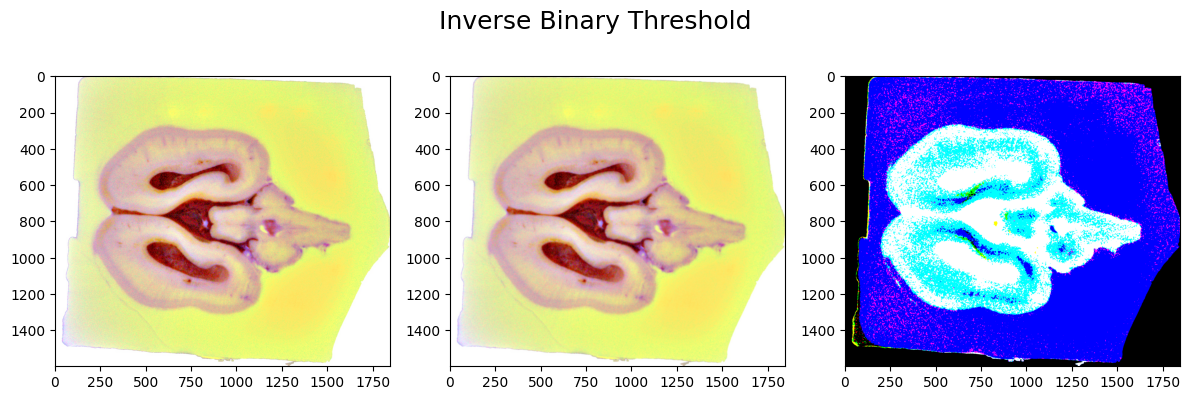

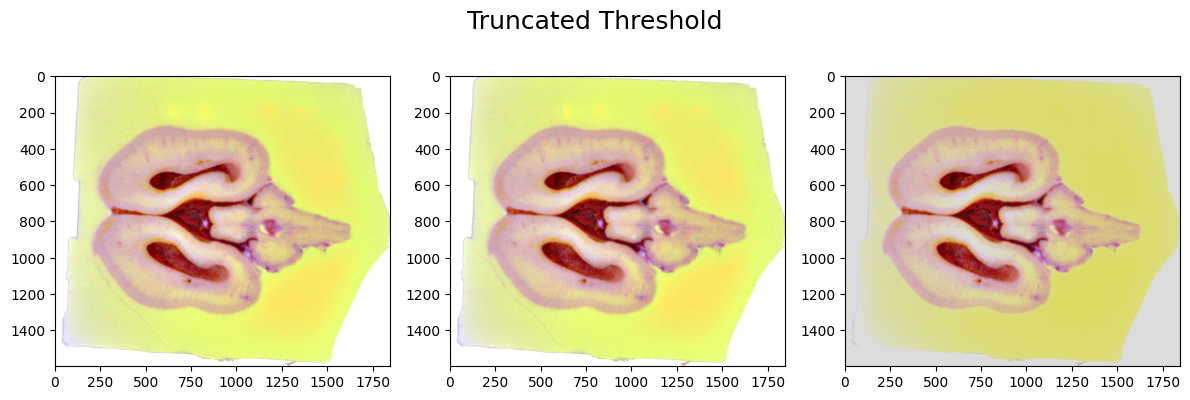

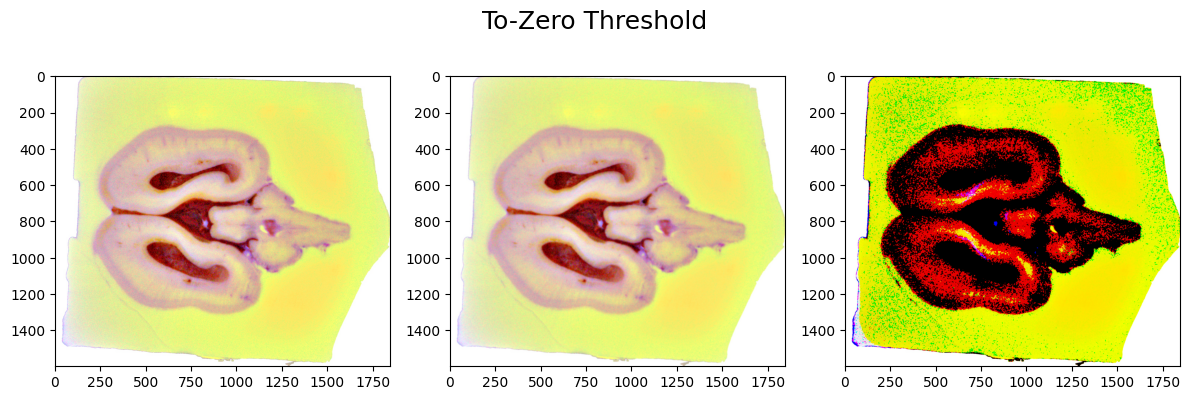

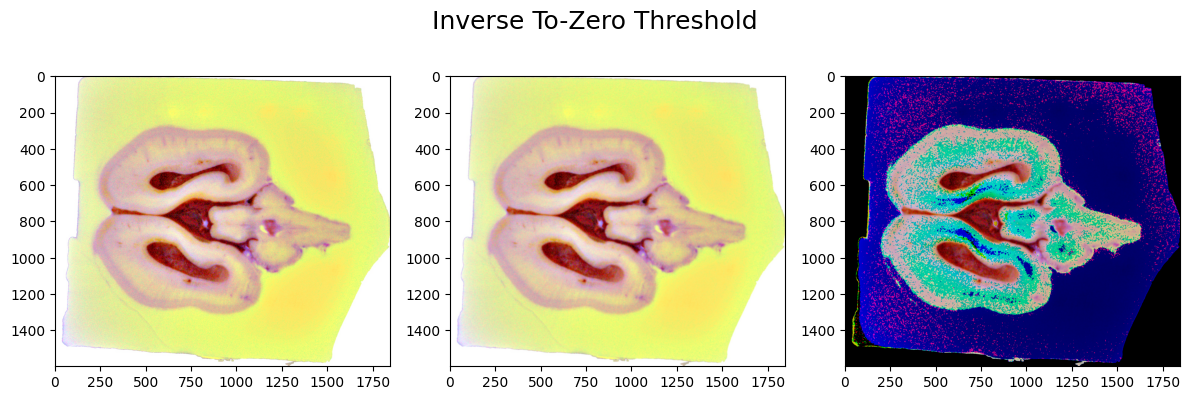

In [129]:
methods = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
names = ['Binary Threshold', 'Inverse Binary Threshold', 'Truncated Threshold', 'To-Zero Threshold', 'Inverse To-Zero Threshold']

def thresh(img_path, method, index):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    ret, img_masked = cv2.threshold(blurred, 220, 255, method)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(names[index], fontsize=18)
    ax[0].imshow(img)
    ax[1].imshow(blurred)
    ax[2].imshow(img_masked)
    plt.tight_layout()

for index, method in enumerate(methods):
    thresh('/storage/valis_reg/test_block_out/msrcr/1620_msrcr.jpg', method, index) 

Threshold: 218.0
Threshold: 252.0


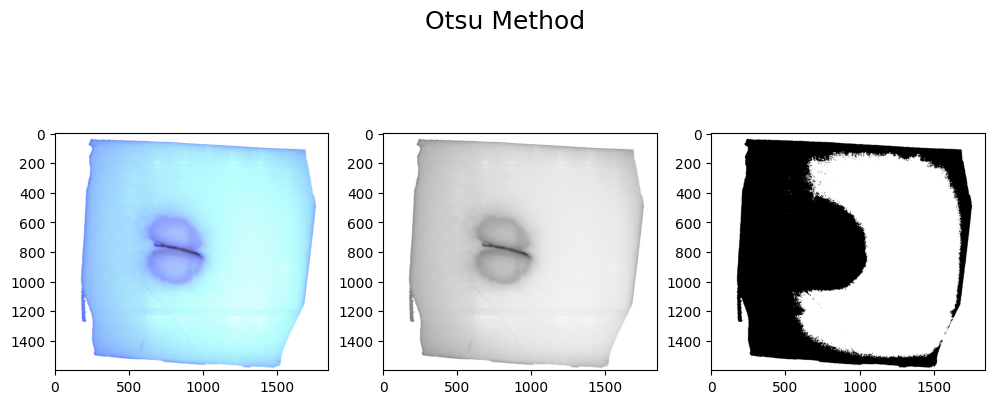

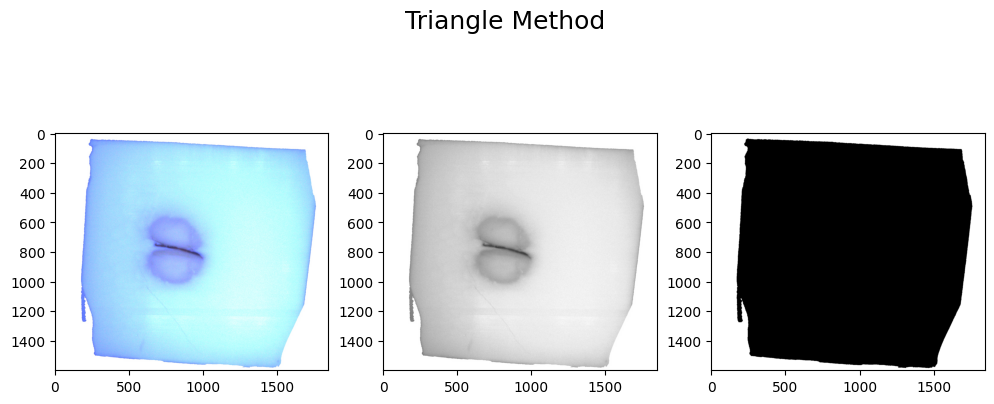

In [110]:
methods = [cv2.THRESH_OTSU, cv2.THRESH_TRIANGLE]
names = ['Otsu Method', 'Triangle Method']

def thresh(img_path, method, index):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    ret, img_masked = cv2.threshold(blurred, 0, 255, method)
    print(f"Threshold: {ret}")

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle(names[index], fontsize=18)
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
    ax[2].imshow(cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB))

for index, method in enumerate(methods):
    thresh('/storage/valis_reg/test_block_out/original/0060.jpg', method, index)